aqui probaremos los modelos de reds neuronales entrenando con imagenes, obteniendo como variables target el tipo de lesion, tanto venigna como maligna 

In [37]:
# Importar las librerías
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE

# Suprimir todos los warnings
import warnings
warnings.filterwarnings('ignore')



# Verificar la GPU disponible
print("GPUs disponibles:", len(tf.config.experimental.list_physical_devices('GPU')))


GPUs disponibles: 1


In [39]:
#cargamos el dataset
df = pd.read_csv ('/Users/luiseduardogarciablanco/Desktop/nueva data cancer/prueba_data_18_19_20/metadata_18_19_20_sin_NaN_code.csv', index_col=0)

# Definir las columnas target y las columnas de entrada (features)
target_columns = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']
input_columns = [col for col in df.columns if col not in target_columns]

# Normalizar las características de entrada
scaler = StandardScaler()
df[input_columns] = scaler.fit_transform(df[input_columns])

# Mostrar la información general del dataset
print(df.info())

# Dividir el DataFrame en entrenamiento y validación
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
# Verificar la distribución de las clases
print(df[target_columns].sum(axis=0))


<class 'pandas.core.frame.DataFrame'>
Index: 53767 entries, 19_ISIC_0000000 to 20_ISIC_9999806
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   MEL                                  53767 non-null  int64  
 1   NV                                   53767 non-null  int64  
 2   BCC                                  53767 non-null  int64  
 3   AK                                   53767 non-null  int64  
 4   BKL                                  53767 non-null  int64  
 5   DF                                   53767 non-null  int64  
 6   VASC                                 53767 non-null  int64  
 7   SCC                                  53767 non-null  int64  
 8   UNK                                  53767 non-null  float64
 9   age_approx                           53767 non-null  float64
 10  sex_female                           53767 non-null  float64
 11  sex_male 

MEL  --  Melanoma
NV   --  Melanocytic nevus
BCC  --  Basal cell carcinoma
AK   --  Actinic keratosis / Bowen’s disease (intraepithelial carcinoma)
BKL  --  Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis)
DF   --  Dermatofibroma
VASC --  Vascular lesion
SCC  --  Squamous cell carcinoma
UNK  --  None of the others

Manejo del desbalanceo de clases con SMOTE

Antes de aplicar SMOTE, es importante aclarar que SMOTE generalmente se usa para datos tabulares. Para datos de imágenes, aumentaremos las imágenes en las clases minoritarias más adelante.

Este bloque aplica SMOTE a las columnas de características para corregir el desbalanceo. Ahora deberías tener un dataset más equilibrado.

debemos asegurarnos de que las muestras resultantes después de aplicar SMOTE para cada clase tengan las mismas dimensiones. La forma más directa de hacerlo es aplicar SMOTE a un conjunto combinado de todas las etiquetas al mismo tiempo, en lugar de hacerlo por separado. Esto nos asegurará que todas las columnas tengan la misma cantidad de muestras.

In [40]:

# Definir las columnas de entrada y target
input_columns = [col for col in df.columns if col not in target_columns]
X = df[input_columns]
y = df[target_columns]

# Combinar las columnas target en un solo array (esto es necesario para que SMOTE funcione correctamente)
y_combined = np.argmax(y.values, axis=1)  # Esto convierte las etiquetas multi-target en una sola

# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled_combined = smote.fit_resample(X, y_combined)

# Volver a expandir las etiquetas combinadas a su forma original
y_resampled = np.zeros((y_resampled_combined.size, y.shape[1]))
y_resampled[np.arange(y_resampled_combined.size), y_resampled_combined] = 1

# Convertir a DataFrame
X_resampled_df = pd.DataFrame(X_resampled, columns=input_columns)
y_resampled_df = pd.DataFrame(y_resampled, columns=target_columns)

# Verificar las nuevas distribuciones de las clases
print(y_resampled_df.sum(axis=0))

MEL     31209.0
NV      31209.0
BCC     31209.0
AK      31209.0
BKL     31209.0
DF      31209.0
VASC    31209.0
SCC     31209.0
dtype: float64


Usaremos ImageDataGenerator de Keras para cargar y aumentar las imágenes de manera eficiente.

primero generamos una columna nueva con el path de cada imagen

In [41]:

'''
# Definir el path de la carpeta de imágenes
image_dir = "/Users/luiseduardogarciablanco/Desktop/nueva data cancer/prueba_data_18_19_20/imagenes"

# Crear una nueva columna 'image_path' en el DataFrame con la ruta completa de cada imagen
df['image_path'] = df.index.to_series().apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))

# Verificar que las rutas se han generado correctamente
df.head()  # Esto debería mostrar las primeras filas del DataFrame con la nueva columna 'image_path'
'''

'\n# Definir el path de la carpeta de imágenes\nimage_dir = "/Users/luiseduardogarciablanco/Desktop/nueva data cancer/prueba_data_18_19_20/imagenes"\n\n# Crear una nueva columna \'image_path\' en el DataFrame con la ruta completa de cada imagen\ndf[\'image_path\'] = df.index.to_series().apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))\n\n# Verificar que las rutas se han generado correctamente\ndf.head()  # Esto debería mostrar las primeras filas del DataFrame con la nueva columna \'image_path\'\n'

In [42]:

# Crear un generador de datos
datagen = ImageDataGenerator(rescale=1./255)  # Normalizar las imágenes entre 0 y 1

# Definir un generador personalizado
def custom_image_generator(df, datagen, batch_size):
    while True:
        # Seleccionar lotes aleatorios
        batch_df = df.sample(n=batch_size)

        # Cargar las imágenes y los labels correspondientes
        images = []
        labels = []
        for i, row in batch_df.iterrows():
            img_path = f'/Users/luiseduardogarciablanco/Desktop/nueva data cancer/prueba_data_18_19_20/imagenes/{row.name}.jpg'
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            images.append(img_array)
            labels.append(row[target_columns].values)  # Asegúrate de que target_columns está bien definida
        
        # Convertir a arrays de numpy
        images = np.array(images)
        labels = np.array(labels)
        
        # Usar el datagen para realizar augmentations si es necesario
        yield datagen.flow(images, labels, batch_size=batch_size).__next__()

# Tamaño del batch
batch_size = 32

# Crear el generador de entrenamiento
train_generator = custom_image_generator(train_df, datagen, batch_size)

# Crear el generador de validación
val_generator = custom_image_generator(val_df, datagen, batch_size)

# Ejemplo de cómo obtener un batch
images, labels = next(train_generator)
print(images.shape, labels.shape)

(32, 256, 256, 3) (32, 8)


Vamos a construir un modelo de red neuronal convolucional (CNN) con soporte para multitarget y agregar Dropout para prevenir el sobreajuste.

In [43]:
# Definir el modelo
model = Sequential()

# Añadir capas de la CNN
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Capa de salida para multitarget
model.add(Dense(len(target_columns), activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Mostrar la estructura del modelo
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 127, 127, 32)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 62, 62, 64)       

Finalmente, entrenaremos el modelo con un callback para reducir la tasa de aprendizaje cuando el entrenamiento se estanque.

Epoch 1/25


2024-08-23 14:14:44.344578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1344/1344 [==============================] - ETA: 0s - loss: 0.1541 - accuracy: 0.3694

2024-08-23 14:16:55.654183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1344/1344 [==============================] - 142s 105ms/step - loss: 0.1541 - accuracy: 0.3694 - val_loss: 0.1320 - val_accuracy: 0.4823 - lr: 0.0010
Epoch 2/25
1344/1344 [==============================] - 142s 105ms/step - loss: 0.1445 - accuracy: 0.4544 - val_loss: 0.1332 - val_accuracy: 0.3546 - lr: 0.0010
Epoch 3/25
1344/1344 [==============================] - 142s 105ms/step - loss: 0.1888 - accuracy: 0.4417 - val_loss: 0.1938 - val_accuracy: 0.2911 - lr: 0.0010
Epoch 4/25
1344/1344 [==============================] - 142s 105ms/step - loss: 0.6496 - accuracy: 0.4030 - val_loss: 0.4824 - val_accuracy: 0.3158 - lr: 0.0010
Epoch 5/25
1344/1344 [==============================] - 141s 105ms/step - loss: 1.4812 - accuracy: 0.3989 - val_loss: 2.2445 - val_accuracy: 0.3024 - lr: 2.0000e-04
Epoch 6/25
1344/1344 [==============================] - 142s 106ms/step - loss: 4.6974 - accuracy: 0.3810 - val_loss: 3.6512 - val_accuracy: 0.6820 - lr: 2.0000e-04


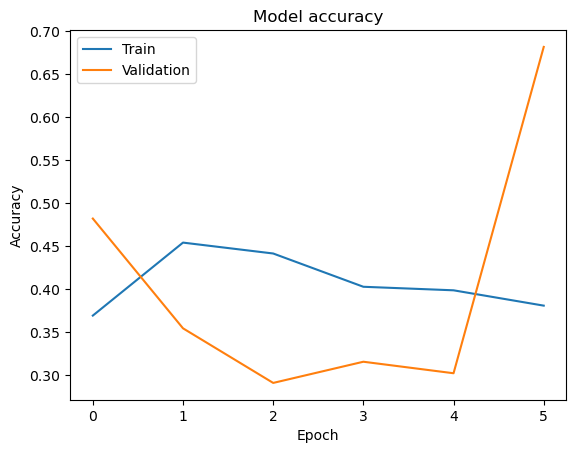

In [44]:
# Definir callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

# Entrenar el modelo
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_df) // 32,
    validation_data=val_generator,
    validation_steps=len(val_df) // 32,
    epochs=25,
    callbacks=[early_stopping, reduce_lr]
)



# Graficar la evolución del entrenamiento
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [46]:
# Guardar el modelo
model.save('/Users/luiseduardogarciablanco/Desktop/bootcamp/Proyecto_Final_Cancer/models/modelo_prueba.h5')

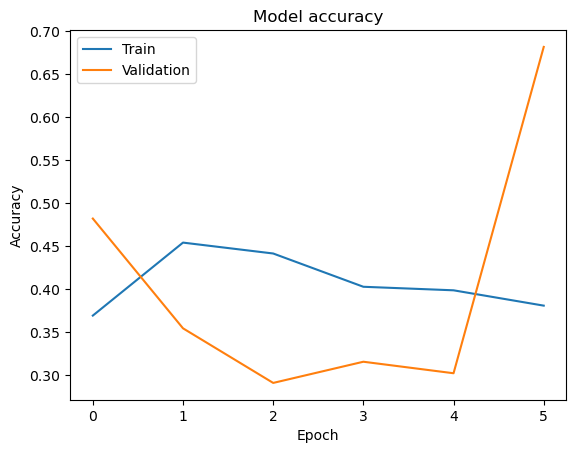

In [47]:
# Graficar la evolución del entrenamiento
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [48]:
# Evaluar el modelo en el conjunto de validación
val_loss, val_accuracy = model.evaluate(val_generator, steps=len(val_df) // batch_size)

print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

336/336 [==============================] - 11s 32ms/step - loss: 0.1343 - accuracy: 0.4749
Validation Loss: 0.13425034284591675
Validation Accuracy: 0.4748883843421936


In [49]:
# Hacer predicciones en el conjunto de validación
val_images, val_labels = next(custom_image_generator(val_df, datagen, batch_size))  # Obtén un batch de datos

# Realizar la predicción
predictions = model.predict(val_images)

# Mostrar las primeras predicciones y las etiquetas reales
print("Predictions:")
print(predictions[:5])

print("True Labels:")
print(val_labels[:5])

1/1 [==============================] - 0s 16ms/step
Predictions:
[[0.1566557  0.35873014 0.04950984 0.01831486 0.08476964 0.00429237
  0.00432544 0.00789329]
 [0.02603152 0.01811418 0.02185223 0.00504113 0.01794935 0.00233563
  0.00311419 0.00496203]
 [0.01663694 0.0133175  0.00998198 0.00268454 0.01011718 0.00093261
  0.00118019 0.00227283]
 [0.29855937 0.4409299  0.36732617 0.10973371 0.20089668 0.08074894
  0.07882529 0.10742828]
 [0.36423516 0.21628283 0.549307   0.11266102 0.16795976 0.01709151
  0.01216203 0.06742866]]
True Labels:
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


In [50]:


# Hacer predicciones en el conjunto de validación
val_images, val_labels = next(custom_image_generator(val_df, datagen, batch_size))
predictions = model.predict(val_images)

# Convertir las predicciones a etiquetas de clase
pred_labels = np.argmax(predictions, axis=1)

# Convertir las etiquetas verdaderas a formato de clase
true_labels = np.argmax(val_labels, axis=1)

# Generar el informe de clasificación
report = classification_report(true_labels, pred_labels, target_names=target_columns)

print("Classification Report:")
print(report)

1/1 [==============================] - 0s 16ms/step


ValueError: Number of classes, 6, does not match size of target_names, 8. Try specifying the labels parameter

In [51]:
target_columns = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF']
from sklearn.metrics import classification_report

# Hacer predicciones en el conjunto de validación
val_images, val_labels = next(custom_image_generator(val_df, datagen, batch_size))
predictions = model.predict(val_images)

# Convertir las predicciones a etiquetas de clase
pred_labels = np.argmax(predictions, axis=1)

# Convertir las etiquetas verdaderas a formato de clase
true_labels = np.argmax(val_labels, axis=1)

# Especificar las etiquetas y nombres de las clases
labels = range(len(target_columns))  # Asegúrate de que esto coincida con el número de clases en tu modelo
report = classification_report(true_labels, pred_labels, labels=labels, target_names=target_columns)

print("Classification Report:")
print(report)

1/1 [==============================] - 0s 16ms/step
Classification Report:
              precision    recall  f1-score   support

         MEL       0.86      0.29      0.43        21
          NV       0.29      0.86      0.43         7
         BCC       0.25      0.50      0.33         2
          AK       0.00      0.00      0.00         1
         BKL       0.00      0.00      0.00         1
          DF       0.00      0.00      0.00         0

   micro avg       0.41      0.41      0.41        32
   macro avg       0.23      0.27      0.20        32
weighted avg       0.64      0.41      0.40        32



hay clases que tienen muy pocas muestras y el dataseet en general aparece muy desbalancado, por eso descartarmos las pruebas multiclase, seguiremos con otras pruebas